In this tutorial you will learn about how visual neuroscientist model the function of simple and complex cells of the type that are found in the primary visual cortex. 

In [1]:
# Some commands needed to get things started

# matplotlib are plotting routines
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# this next command tells matplotlib to display figures inside the notebook
# using a particular system that allows for animations
%matplotlib nbagg

#numpy is a numerical library
import numpy as np

# simple is a custom library that we will use for this tutorial - it contains
# functions to simulate simple and complex cells
import simple


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


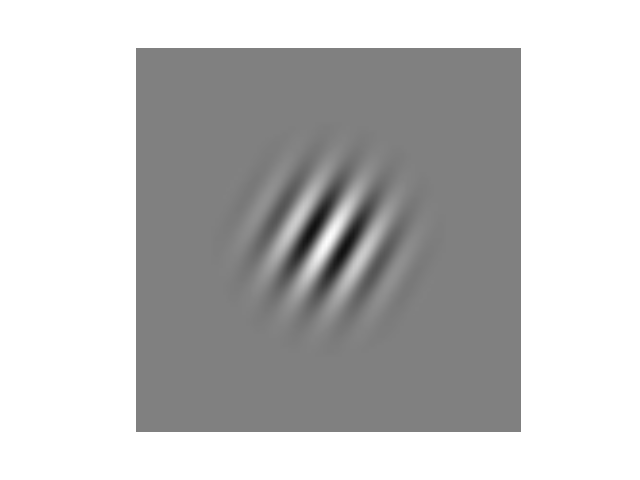

In [2]:
gabor = simple.gaussian()*simple.grating(orient=30)
simple.imshow(gabor)

<IPython.core.display.Javascript object>


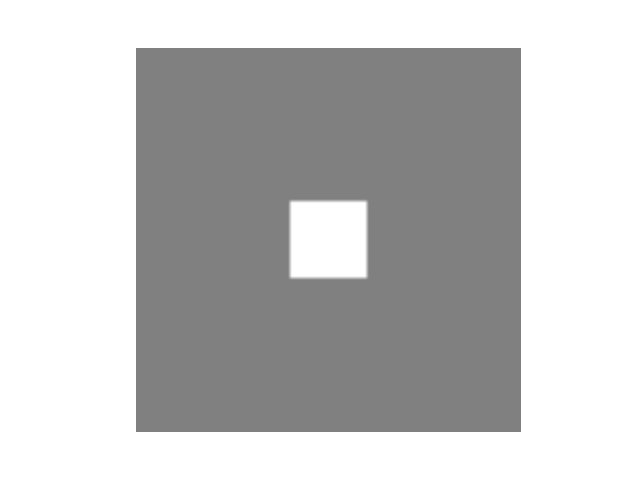

In [3]:
spot = simple.spot()
simple.imshow(spot)

<IPython.core.display.Javascript object>


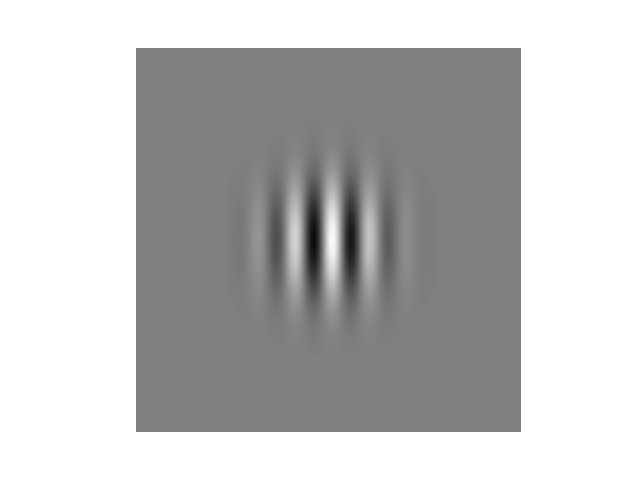

In [4]:
# make a drifting grating
nFrames = 50;
iFrame = 0;
driftingGrating = np.zeros((100,100,nFrames))
for iPhase in np.linspace(0,360,nFrames):
    driftingGrating[:,:,iFrame] = simple.grating(phase=iPhase)*simple.gaussian()
    iFrame = iFrame+1

# display the stimulus
a = simple.makeAnimation(driftingGrating)
plt.show()

<IPython.core.display.Javascript object>


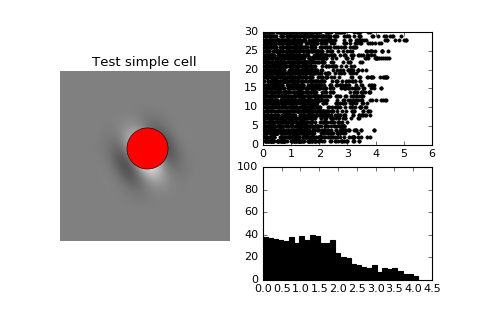

In [194]:
import numpy as np
import scipy.io.wavfile as wavfile
from IPython.display import Audio
%matplotlib nbagg
#######################
#    spotStimulate    #
#######################
class spotStimulate:
    # class initializer
    def __init__(self, plt, neuronSim, stimDur = 2):
        # load pop sound (wanted to use this to make an action potential sound)
        # but does not seem to work from within the class - perhaps this is 
        # because it doesn't have anywhere to display to?
        # self.rate,self.pop = wavfile.read('popshort.wav')
        # keep the cell we are simulating
        self.neuronSim = neuronSim
        # keep how long the stimulus will be on for
        self.stimDur = stimDur;
        # keep plt
        self.plt = plt
        # setup figure
        self.f = plt.figure()
        self.rasterAxis = self.f.add_subplot(222)
        self.responseAxis = self.f.add_subplot(224)
        self.stimAxis = self.f.add_subplot(121)
        plt.axis('off')
        # set axis
        self.stimAxis.set_title('Test simple cell')
        # set callback for button presses
        self.cid = self.f.canvas.mpl_connect('button_press_event', self)
    # button press callback
    def __call__(self, event):
        if event.dblclick:
            print('double click')
        else:
            # check if event is on axis
            if event.inaxes!=self.stimAxis: return
            # get x, y corridnates
            #self.x1.append([event.xdata,event.ydata])
            x,y = simple.xycoords()
            spot = simple.spot(event.xdata,event.ydata,0.5,0.5)
            # get response of simulated neuron
            response = self.neuronSim.getResponse(spot)
            #plotSpikeTrains(response)

            # and plot them
            #markerSize = np.max(1,response)
            self.stimAxis.plot(event.xdata,event.ydata,'ro',markersize=response)
            global xDeg, yDeg
            # FIX, why do I have to hardcode the 5's - want them to be xDeg/2
            # self.plt.imshow(spot,cmap="gray",vmin=-1,vmax=1,extent=(-5,5,-5,5),origin='center')        
            self.stimAxis.imshow(self.neuronSim.rf,cmap="gray",vmin=-1,vmax=1,extent=(-5,5,-5,5),origin='center')  
            # play a sound train (see above on __init__ this doesn't work)
            #Audio(data=self.pop,rate=self.rate,autoplay=True)
            # now make spike trains - this needs to be fixed - since it computes
            # always the same number of spikes per trial which makes things weird.
            baselineDur = 2
            stimDur = 2
            totalDur = baselineDur + stimDur
            spikeRate = response
            baselineSpikeRate = 10
            nSpikes = spikeRate * stimDur
            nBaselineSpikes = baselineSpikeRate * baselineDur
            nSpikeTrains = 30
            # choose spike times from an exponential distribution
            spikeTimes = np.random.exponential(1/spikeRate,(nSpikeTrains,nSpikes))
            spikeTimesBaseline = np.random.exponential(1/baselineSpikeRate,(nSpikeTrains,nBaselineSpikes))
            # 
            spikeTimes = np.cumsum(np.concatenate((spikeTimes,spikeTimesBaseline),axis=1),axis=1)
            # location to plot each row
            spikePlotY = np.cumsum(np.ones((nSpikeTrains,nSpikes+nBaselineSpikes)),axis=0)

            nBins = 30
            averageSpikeRate = np.ones(nBins)
            for binNum in range(nBins):
                beginInterval = totalDur*(binNum)/nBins
                endInterval = totalDur*(binNum+1)/nBins
                averageSpikeRate[binNum] = (nBins/totalDur) * (np.sum((spikeTimes<endInterval) & (spikeTimes>=beginInterval)))/nSpikeTrains
            averageSpikeRate
            binWidth = totalDur/nBins
            np.linspace(0,stimDur,nBins)
            self.responseAxis.cla()
            self.responseAxis.bar(np.linspace(0,totalDur,nBins),averageSpikeRate,binWidth,color='k')
            self.responseAxis.set_ylim([0,100])
            self.rasterAxis.cla()
            self.rasterAxis.plot(spikeTimes,spikePlotY,'k.')
            self.rasterAxis.ylim([0,nSpikeTrains+1])


class simpleCell:
    def __init__(self,xCenter=0,yCenter=0,sf=0.3,orient=30,xStd=1,yStd=1,restingFR=10,maxFR=100,exponent=1):
        # create receptive field
        self.rf = simple.gaussian(xStd=xStd,yStd=yStd)*simple.grating(sf=sf,orient=orient)
        # set parameters
        self.restingFR = restingFR
        self.maxFR = maxFR
        # static nonlinearity
        self.exponent = exponent
        # compute normalizing constant (i.e. maximum possible response)
        self.norm = np.sum(self.rf * self.rf)
    def getResponse(self,stim):
        # multiply stimulus with rf (Will give a number between 1 and -1)
        response = np.sum(self.rf * stim)/self.norm
        # turn into firing rate with max of maxFR and min of 0
        response = self.restingFR + (self.maxFR-self.restingFR) * response
        response = max(response,0)
        # apply exponent, Fix, Fix this doesn't seem like the right place for this
        response = response ** self.exponent
        # pull from a poisson distribution actual firing rate
        response = np.random.poisson(response)
        # plot some spike trains
        return(response)

simpleCellSim = simpleCell()
#simple.imshow(simpleCellSim.rf)
uhm = spotStimulate(plt,simpleCellSim)

rate,pop = wavfile.read('popshort.wav')
Audio(data=pop,rate=rate,autoplay=True)

In [33]:


#simple.imshow(x.rf)
spot = simple.spot(xCenter=0)
print(x.getResponse(spot))

NameError: name 'x' is not defined

In [11]:
import numpy as np
import scipy.io.wavfile as wavfile
from IPython.display import Audio

# load pop sound and play
#rate,pop = wavfile.read('pop.wav')
rate,pop = wavfile.read('popshort.wav')
# note that we can only seem to play mono so select 0th channel
Audio(data=pop,rate=rate,autoplay=True)

In [223]:
print(32767*2+1)
print(np.max(pop))
print(np.min(pop))


65535
32512
-32768


In [20]:
spotStimulate.rate

AttributeError: type object 'spotStimulate' has no attribute 'rate'

<IPython.core.display.Javascript object>


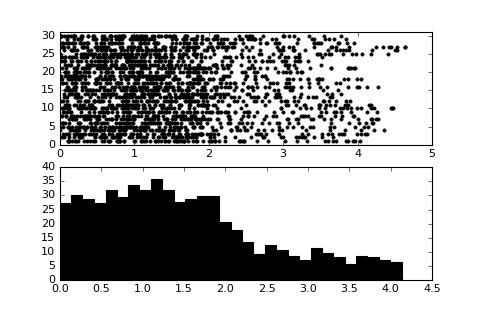

(0, 31)

In [178]:
baselineDur = 2
stimDur = 2
totalDur = baselineDur + stimDur
spikeRate = 30
baselineSpikeRate = 10
nSpikes = spikeRate * stimDur
nBaselineSpikes = baselineSpikeRate * baselineDur
nSpikeTrains = 30
spikeTimes = np.random.exponential(1/spikeRate,(nSpikeTrains,nSpikes))
spikeTimesBaseline = np.random.exponential(1/baselineSpikeRate,(nSpikeTrains,nBaselineSpikes))
spikeTimes = np.cumsum(np.concatenate((spikeTimes,spikeTimesBaseline),axis=1),axis=1)

spikePlotY = np.cumsum(np.ones((nSpikeTrains,nSpikes+nBaselineSpikes)),axis=0)

nBins = 30
averageSpikeRate = np.ones(nBins)
for binNum in range(nBins):
    beginInterval = totalDur*(binNum)/nBins
    endInterval = totalDur*(binNum+1)/nBins
    averageSpikeRate[binNum] = (nBins/totalDur) * (np.sum((spikeTimes<endInterval) & (spikeTimes>=beginInterval)))/nSpikeTrains
averageSpikeRate
f = plt.figure()
a = f.add_subplot(212)
binWidth = totalDur/nBins
np.linspace(0,stimDur,nBins)
a.bar(np.linspace(0,totalDur,nBins),averageSpikeRate,binWidth,color='k')
a = f.add_subplot(211)
plt.plot(spikeTimes,spikePlotY,'k.')
plt.ylim([0,nSpikeTrains+1])

<IPython.core.display.Javascript object>


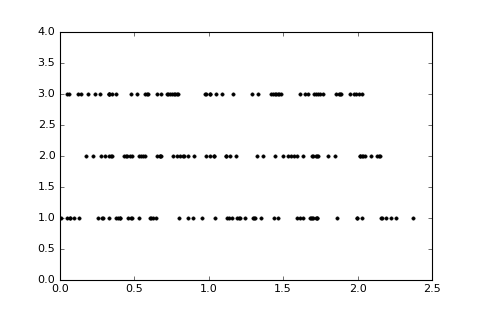

(0, 4)

In [119]:
f = plt.figure()
plt.plot(spikeTimes,spikePlotY,'k.')
spikeTimes
plt.ylim([0,4])